In [ ]:
!pip3 install -U ucimlrepo

## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from random import random, randint, sample
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from scipy.optimize import linear_sum_assignment

## Load Dataset

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
iris = fetch_ucirepo(id=53)

In [ ]:
# Load and prepare the train data
df = iris.data.features
df

,sepal length,sepal width,petal length,petal width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [ ]:
# Load and prepare the test data
y = iris.data.targets
y

,class
0,Iris-setosa
1,Iris-setosa
2,Iris-setosa
3,Iris-setosa
4,Iris-setosa
...,...
145,Iris-virginica
146,Iris-virginica
147,Iris-virginica
148,Iris-virginica


In [ ]:
true_labels = y.values.ravel()

## variables Initialization

In [ ]:
# Parameters
genome_size = len(df)
num_clusters = 3
population_size = 50
max_generations = 100
mutation_rate = 0.01
tournament_size = 3

## Population

In [ ]:
def initialize_population():
    population = []
    for _ in range(population_size):
        individual = [randint(1, num_clusters) for _ in range(genome_size)]
        population.append(individual)
    return population

## Euclidean Distance

In [ ]:
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((np.array(point1) - np.array(point2)) ** 2))

## Mean Cluster

In [ ]:
# Find cluster center as mean of attributes
def find_cluster_center(cluster):
    return np.mean(cluster, axis=0)

## Fitness

In [ ]:
# Fitness function based on accuracy
def accuracy_fitness(individual, df, true_labels):
    clusters = {i: [] for i in range(1, num_clusters + 1)}
    for i, cluster_id in enumerate(individual):
        clusters[cluster_id].append(i)  # Store index of data point

    correct_assignments = 0
    for cluster_points in clusters.values():
        cluster_labels = true_labels[cluster_points]
        cluster_labels_numeric = LabelEncoder().fit_transform(cluster_labels)  # Convert labels to numeric
        if len(cluster_labels_numeric) > 0:
            most_common_label = np.bincount(cluster_labels_numeric).argmax()
            correct_assignments += np.sum(cluster_labels_numeric == most_common_label)

    return correct_assignments / len(true_labels)

## Selection

In [ ]:
# Selection using tournament selection
def selection(population, fitnesses):
    tournament = [population[randint(0, population_size - 1)] for _ in range(tournament_size)]
    tournament_fitnesses = [fitnesses[population.index(ind)] for ind in tournament]
    return tournament[tournament_fitnesses.index(max(tournament_fitnesses))]

## Crossover

In [ ]:
def crossover(parent1, parent2):
    child1 = []
    child2 = []
    for gene1, gene2 in zip(parent1, parent2):
        if random() < 0.5:
            child1.append(gene1)
            child2.append(gene2)
        else:
            child1.append(gene2)
            child2.append(gene1)
    return child1, child2

## Mutation

In [ ]:
def mutate(individual, mutation_rate):
    for i in range(len(individual)):
        if random() < mutation_rate:
            individual[i] = randint(1, num_clusters)

## Genetic algorithm

In [ ]:
def genetic_algorithm():
    population = initialize_population()
    best_individual = None
    best_fitness = -float('inf')
    best_accuracy = -float('inf')
    fitness_over_time = []
    accuracy_over_time = []

    for generation in range(max_generations):
        fitnesses = [accuracy_fitness(ind, df, true_labels) for ind in population]

        # Elitism: Keep the best individual unchanged
        best_index = np.argmax(fitnesses)
        if fitnesses[best_index] > best_fitness:
            best_individual = population[best_index]
            best_fitness = fitnesses[best_index]
            best_accuracy = calculate_accuracy(best_individual, true_labels)

        new_population = [best_individual[:]]  # Start with best individual

        # Selection, crossover, and mutation
        for _ in range(population_size // 2):
            parent1 = selection(population, fitnesses)
            parent2 = selection(population, fitnesses)
            child1, child2 = crossover(parent1, parent2)
            mutate(child1, mutation_rate)
            mutate(child2, mutation_rate)
            new_population.extend([child1, child2])

        population = new_population[:population_size]

        # Record fitness and accuracy
        fitness_over_time.append(best_fitness)
        accuracy_over_time.append(best_accuracy)

        print(f"Generation {generation+1}: Best Fitness = {best_fitness:.2f}, Best Accuracy = {best_accuracy:.2f}")

    # Plot fitness and accuracy over generations
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fitness_over_time)
    plt.xlabel('Generation')
    plt.ylabel('Best Fitness')
    plt.title('Fitness Over Generations')

    plt.subplot(1, 2, 2)
    plt.plot(accuracy_over_time)
    plt.xlabel('Generation')
    plt.ylabel('Best Accuracy')
    plt.title('Accuracy Over Generations')

    plt.show()

    return best_individual, best_fitness, best_accuracy

## Accuracy

In [ ]:
def calculate_accuracy(individual, true_labels):
    clusters = {i: [] for i in range(1, num_clusters + 1)}
    for i, cluster_id in enumerate(individual):
        clusters[cluster_id].append(i)  # Store index of data point

    correct_assignments = 0
    for cluster_points in clusters.values():
        cluster_labels = true_labels[cluster_points]
        cluster_labels_numeric = LabelEncoder().fit_transform(cluster_labels)  # Convert labels to numeric
        if len(cluster_labels_numeric) > 0:
            most_common_label = np.bincount(cluster_labels_numeric).argmax()
            correct_assignments += np.sum(cluster_labels_numeric == most_common_label)

    return correct_assignments / len(true_labels)

## Visualize Clusters

In [ ]:
def visualize_clusters(individual, df):
    plt.figure(figsize=(10, 6))

    # Convert cluster assignment to numpy array for easier handling
    cluster_assignments = np.array(individual)

    # Plot each cluster with different color
    for cluster_id in range(1, num_clusters + 1):
        cluster_points = df[cluster_assignments == cluster_id]
        plt.scatter(cluster_points.iloc[:, 0], cluster_points.iloc[:, 1], label=f'Cluster {cluster_id}')

    plt.xlabel('Sepal Length')
    plt.ylabel('Sepal Width')
    plt.title('Cluster Assignments')
    plt.legend()
    plt.show()

## Execution

Generation 1: Best Fitness = 0.47, Best Accuracy = 0.47
Generation 2: Best Fitness = 0.47, Best Accuracy = 0.47
Generation 3: Best Fitness = 0.48, Best Accuracy = 0.48
Generation 4: Best Fitness = 0.51, Best Accuracy = 0.51
Generation 5: Best Fitness = 0.51, Best Accuracy = 0.51
Generation 6: Best Fitness = 0.51, Best Accuracy = 0.51
Generation 7: Best Fitness = 0.52, Best Accuracy = 0.52
Generation 8: Best Fitness = 0.53, Best Accuracy = 0.53
Generation 9: Best Fitness = 0.57, Best Accuracy = 0.57
Generation 10: Best Fitness = 0.58, Best Accuracy = 0.58
Generation 11: Best Fitness = 0.59, Best Accuracy = 0.59
Generation 12: Best Fitness = 0.62, Best Accuracy = 0.62
Generation 13: Best Fitness = 0.62, Best Accuracy = 0.62
Generation 14: Best Fitness = 0.64, Best Accuracy = 0.64
Generation 15: Best Fitness = 0.64, Best Accuracy = 0.64
Generation 16: Best Fitness = 0.65, Best Accuracy = 0.65
Generation 17: Best Fitness = 0.65, Best Accuracy = 0.65
Generation 18: Best Fitness = 0.67, Best

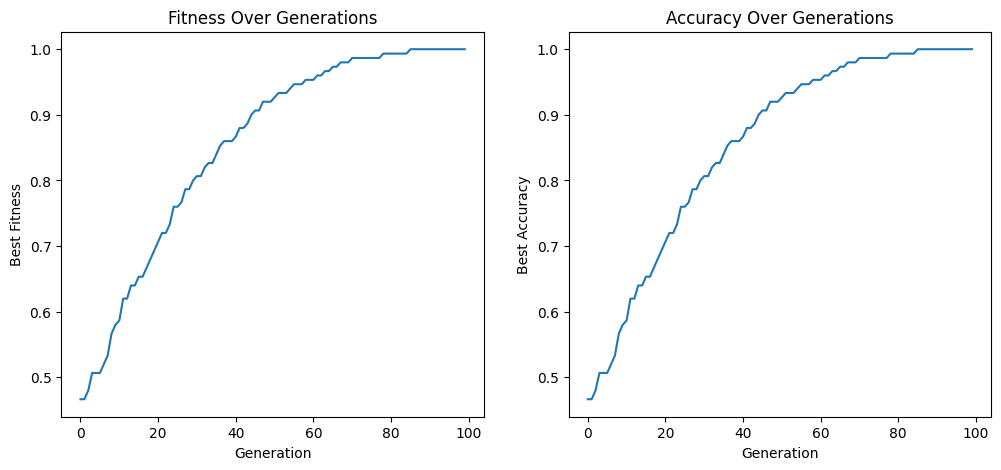

Best Individual (Cluster Assignment): [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Best Fitness: 1.00
Best Accuracy: 1.00


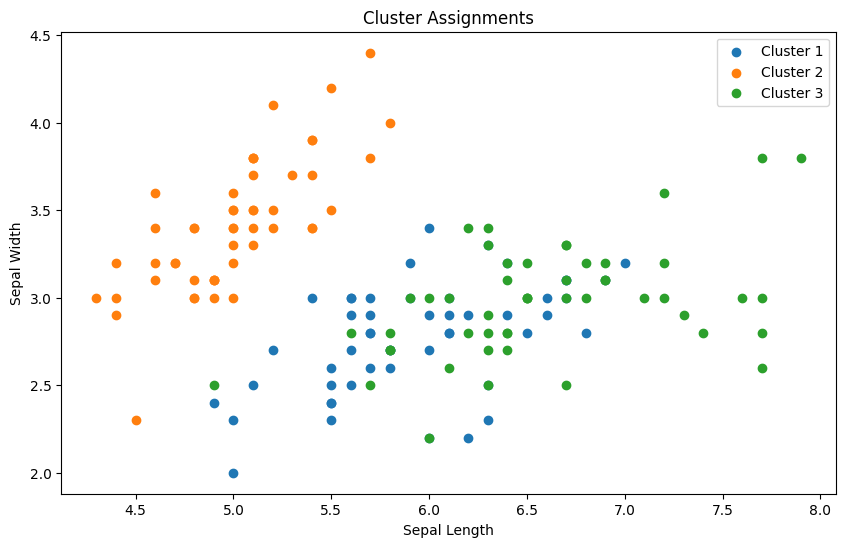

In [ ]:
# Run the genetic algorithm
best_individual, best_fitness, best_accuracy = genetic_algorithm()
print("Best Individual (Cluster Assignment):", best_individual)
print(f"Best Fitness: {best_fitness:.2f}")
print(f"Best Accuracy: {best_accuracy:.2f}")

# Visualize the best cluster assignment
visualize_clusters(best_individual, df)

## K-mean Clustering

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


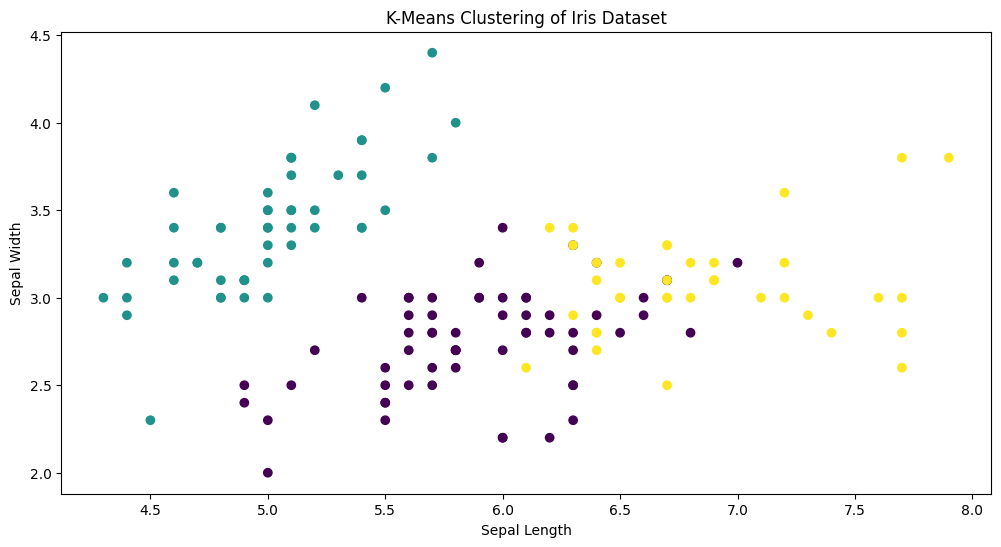

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


# fetch dataset
iris = fetch_ucirepo(id=53)

# Load and prepare the train data
data = iris.data.features

data['target'] = iris.target

# Initialize KMeans with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)

# Fit the model
kmeans.fit(data.drop('target', axis=1))

# Add the cluster labels to the dataset
data['cluster'] = kmeans.labels_

# Plot the results
plt.figure(figsize=(12, 6))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=data['cluster'], cmap='viridis')
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.title('K-Means Clustering of Iris Dataset')
plt.show()
